**For tqdm progress bar to work correctly, before launching this notebook run:**
```bash
$ jupyter nbextension enable --py --sys-prefix widgetsnbextension
```

**Also for GIF to appear launch jupyter as follows:**
```bash
$ jupyter notebook --NotebookApp.iopub_data_rate_limit=100000000
```

**Or simply run from project root:**
```bash
$ make jupyter
```
### imports

In [1]:
import numpy as np
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import matplotlib
import matplotlib.pyplot as plt
from JSAnimation.IPython_display import display_animation
from sklearn.metrics import accuracy_score, confusion_matrix

import env
from bm.dbm import DBM
from bm.rbm import GaussianRBM, MultinomialRBM
from bm.utils import (progress_bar, Stopwatch, RNG,
                      im_plot, im_reshape, im_gif, tick_params, plot_confusion_matrix)
from bm.utils.dataset import (load_cifar10, plot_cifar10, get_cifar10_labels,
                              im_unflatten, im_rescale)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## load CIFAR-10

In [2]:
X, y = load_cifar10(mode='train', path='../data/')
RNG(seed=42).shuffle(X)
RNG(seed=42).shuffle(y)
print X.shape, y.shape

(50000, 3072) (50000,)


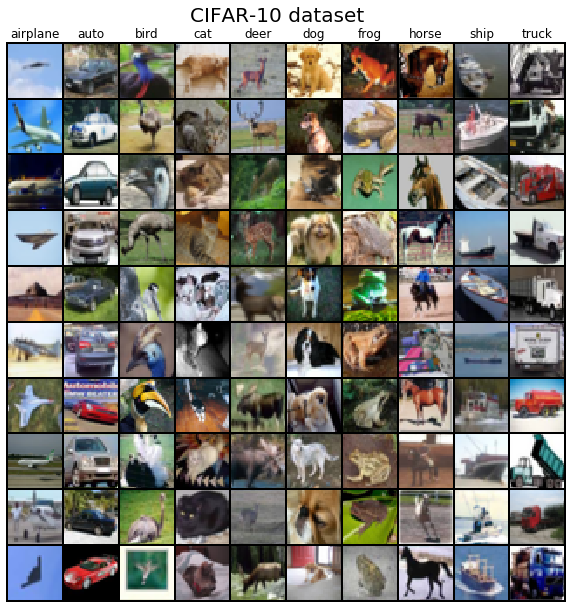

In [3]:
plt.figure(figsize=(10, 10))
plot_cifar10(im_unflatten(X[:1000]), y[:1000], samples_per_class=10)
plt.savefig('cifar10.png', dpi=196, bbox_inches='tight')

## load smoothed CIFAR-10 

In [4]:
X_s = np.load('../data/X_s.npy')
print X_s.shape, X_s.dtype

(49000, 3072) float32


#### (the difference is hardly visible, though)

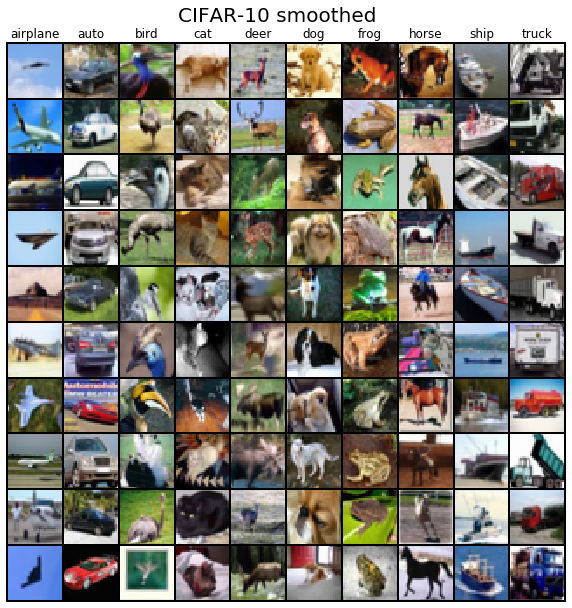

In [5]:
plt.figure(figsize=(10, 10))
plot_cifar10(im_rescale(X_s[:1000]), y[:1000], 
             samples_per_class=10, title='CIFAR-10 smoothed')
plt.savefig('cifar10_smoothed.png', dpi=196, bbox_inches='tight')

## load pre-trained Gaussian RBM

(3072, 5000)


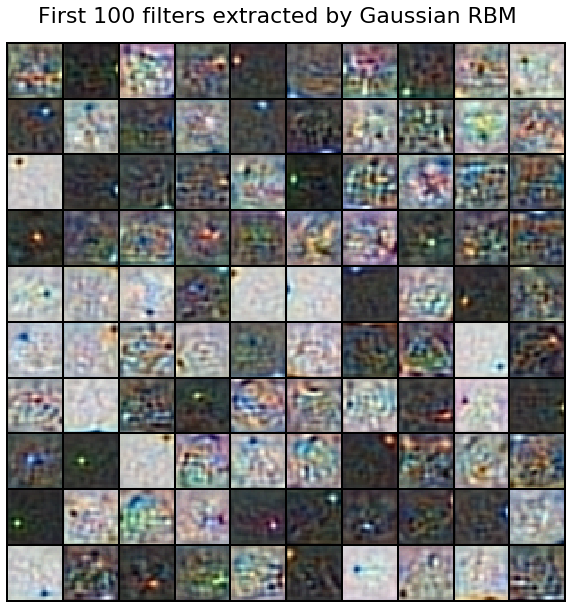

In [6]:
# load RBM weights
grbm = GaussianRBM.load_model('../models/grbm_cifar_naive/')
grbm_W = grbm.get_tf_params(scope='weights')['W']
print grbm_W.shape

# prepare for plotting
W = im_rescale( grbm_W.copy().T )

# plot
fig = plt.figure(figsize=(10, 10))
im_plot(W, title='First 100 filters extracted by Gaussian RBM')
plt.savefig('dbm_cifar_naive_grbm.png', dpi=196, bbox_inches='tight');

## load pre-trained Multinomial RBM

(5000, 1000)


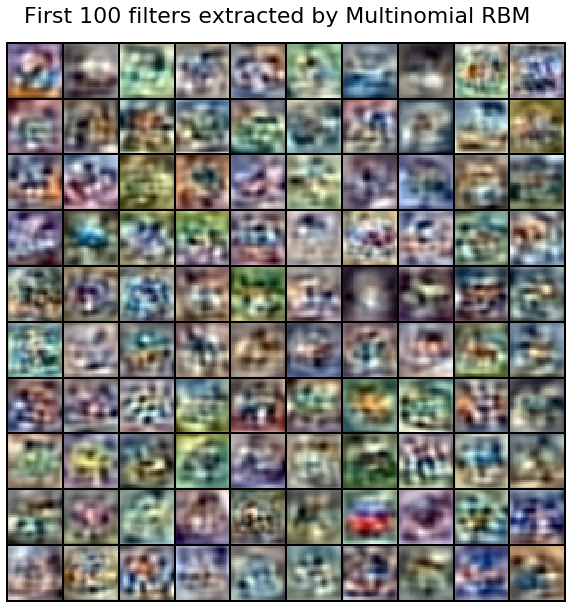

In [7]:
# load RBM weights
mrbm = MultinomialRBM.load_model('../models/mrbm_cifar_naive/')
mrbm_W = mrbm.get_tf_params(scope='weights')['W']
print mrbm_W.shape

# prepare for plotting
W = grbm_W.dot(mrbm_W)
W = im_rescale( W.T )

# plot
fig = plt.figure(figsize=(10, 10))
im_plot(W, title='First 100 filters extracted by Multinomial RBM')
plt.savefig('dbm_cifar_naive_mrbm.png', dpi=196, bbox_inches='tight');

## load trained DBM and visualize filters in layers 1 and 2

In [8]:
dbm = DBM.load_model('../models/dbm_cifar_naive/')
dbm.load_rbms([grbm, mrbm])  # !!!

In [9]:
weights = dbm.get_tf_params('weights')
W1 = weights['W']
W2 = weights['W_1']
print W1.shape, W2.shape

(3072, 5000) (5000, 1000)


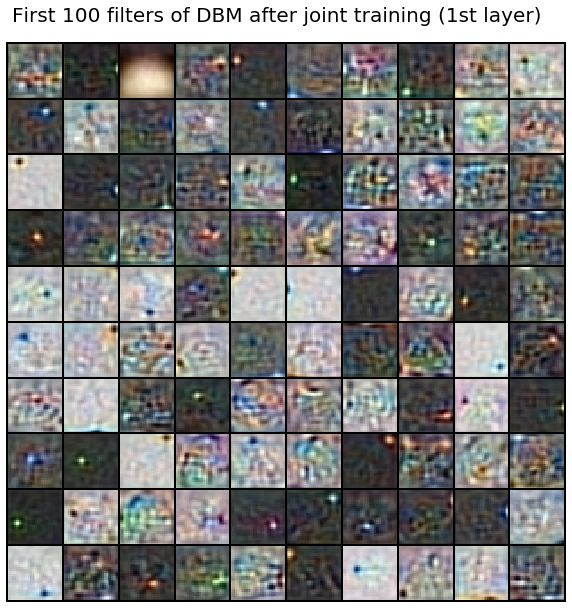

In [10]:
# prepare for plotting
W = im_rescale( W1.T )

# plot
fig = plt.figure(figsize=(10, 10))
im_plot(W, title='First 100 filters of DBM after joint training (1st layer)',
        title_params={'fontsize': 20})
plt.savefig('dbm_cifar_naive_W1_joint.png', dpi=196, bbox_inches='tight');

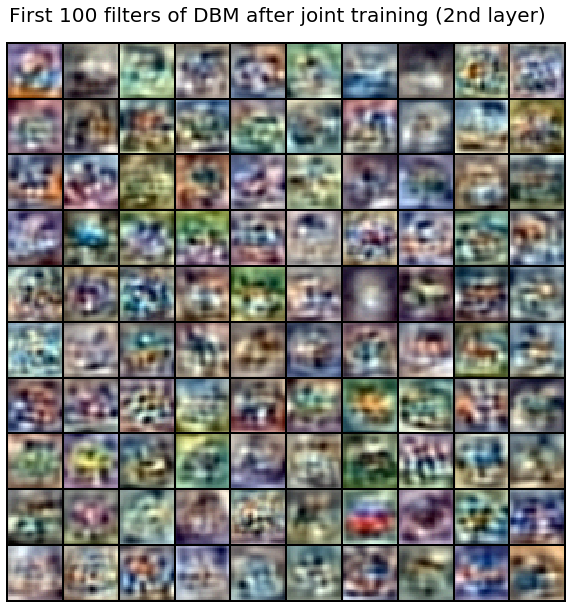

In [11]:
# prepare for plotting
W = W1.dot(W2)
W = im_rescale( W.T )

# plot
fig = plt.figure(figsize=(10, 10))
im_plot(W, title='First 100 filters of DBM after joint training (2nd layer)', 
        title_params={'fontsize': 20})
plt.savefig('dbm_cifar_naive_W2_joint.png', dpi=196, bbox_inches='tight');

# generate samples after training

In [12]:
X_s_mean = np.load('../data/X_s_mean.npy')
X_s_std = np.load('../data/X_s_std.npy')

In [13]:
V = dbm.sample_v(n_gibbs_steps=10)
print V.shape

(100, 3072)


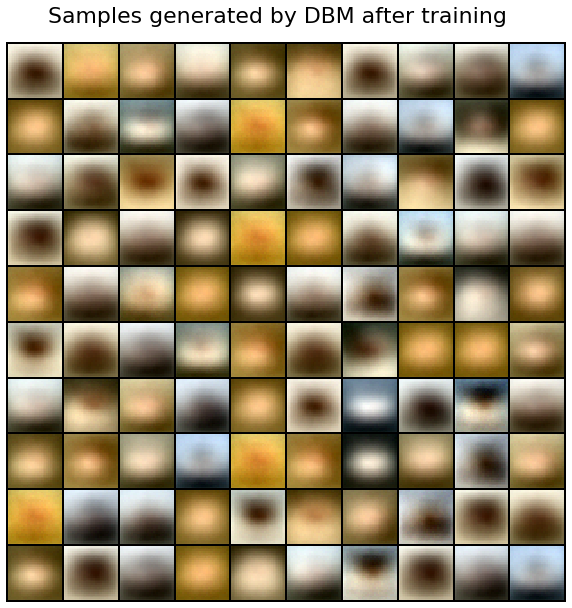

In [14]:
# prepare for plotting
V = im_rescale(V, mean=X_s_mean, std=X_s_std)

# plot
fig = plt.figure(figsize=(10, 10))
im_plot(V, title='Samples generated by DBM after training');
plt.savefig('dbm_cifar_naive_samples.png', dpi=196, bbox_inches='tight');

## generate more samples
**(note that new samples override previous particles on disk)**

In [15]:
V = im_reshape(V, n_width=10, n_height=10)
samples = [V]
for i in progress_bar(range(10)):
    V = dbm.sample_v(n_gibbs_steps=50, save_model=True)
    V = im_rescale(V, mean=X_s_mean, std=X_s_std)
    V = im_reshape(V, n_width=10, n_height=10)
    samples.append(V)

A Jupyter Widget

## make an animation and save to disk


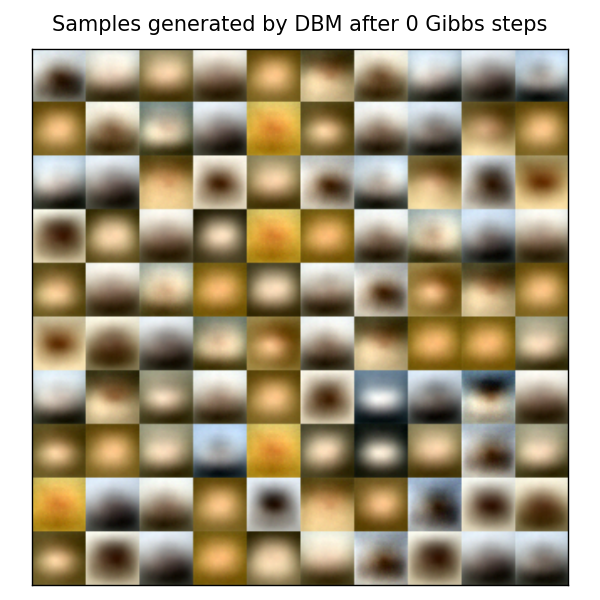
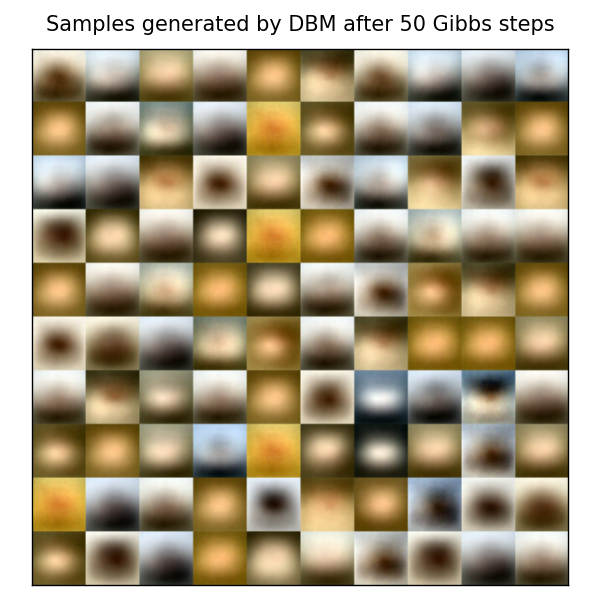
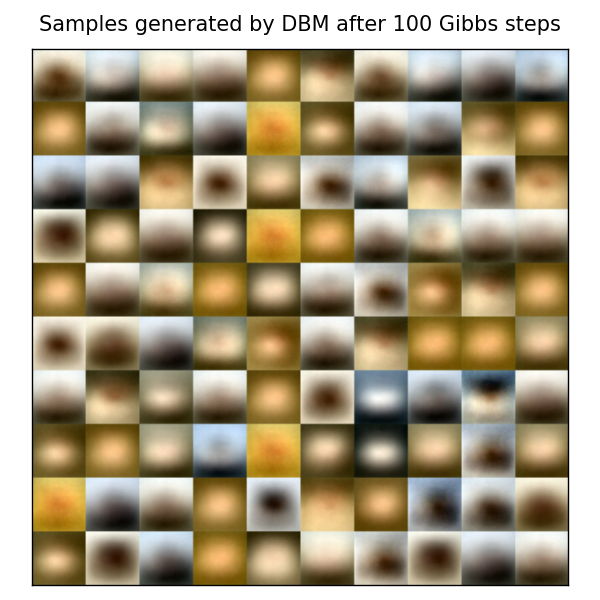
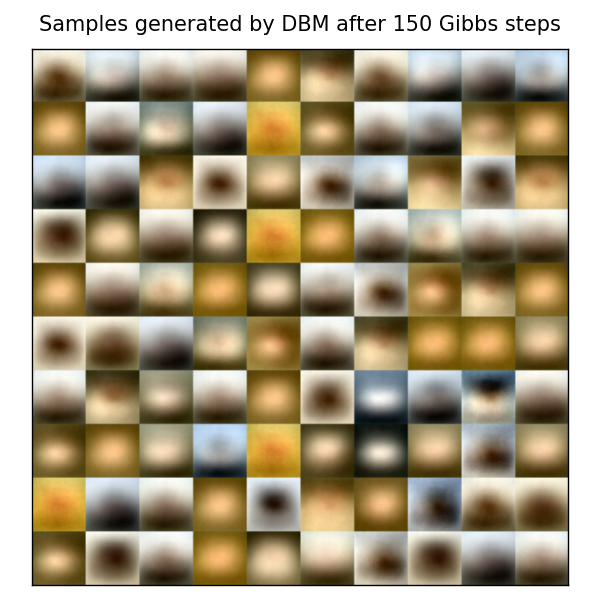
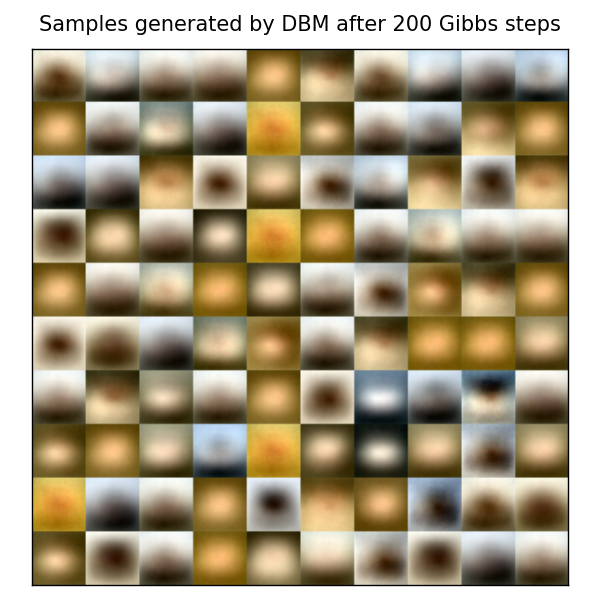
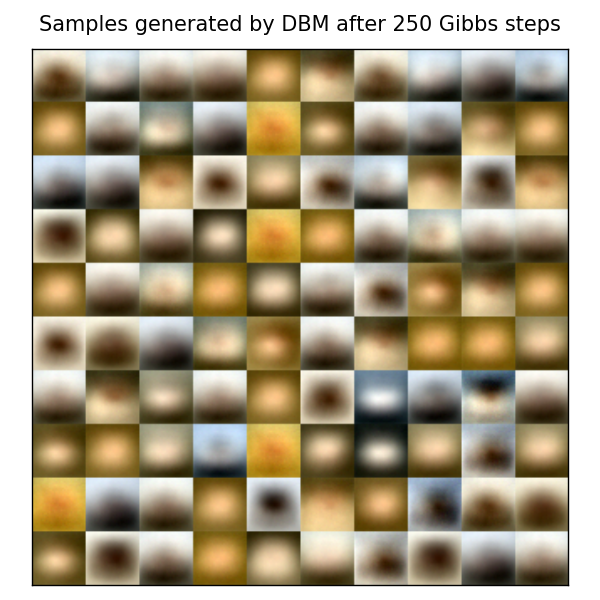
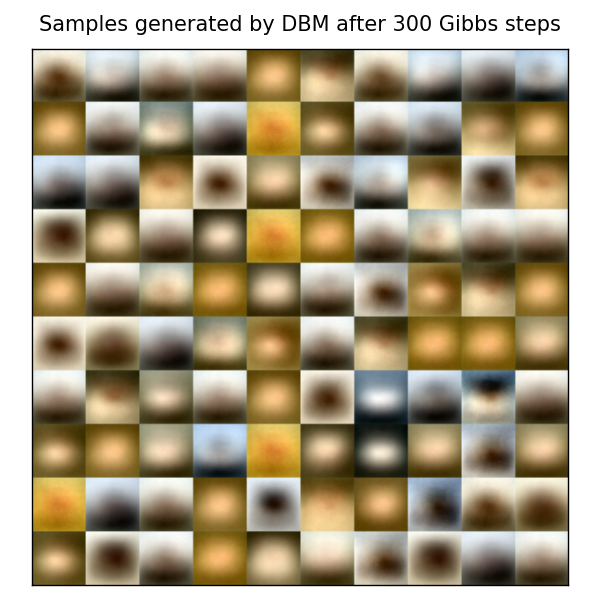
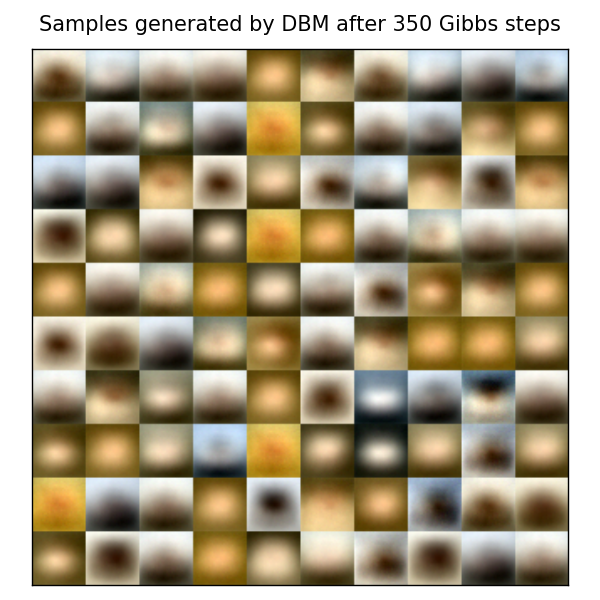
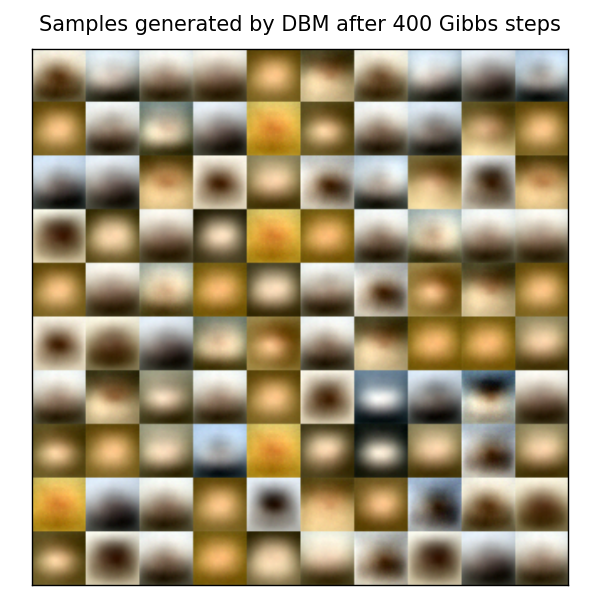
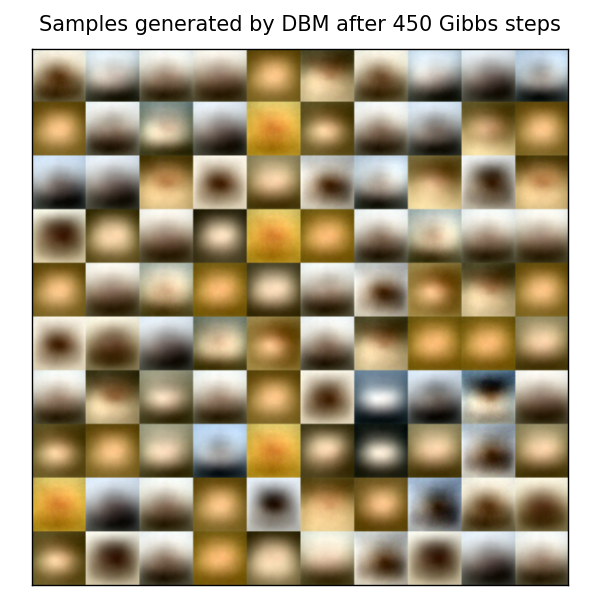
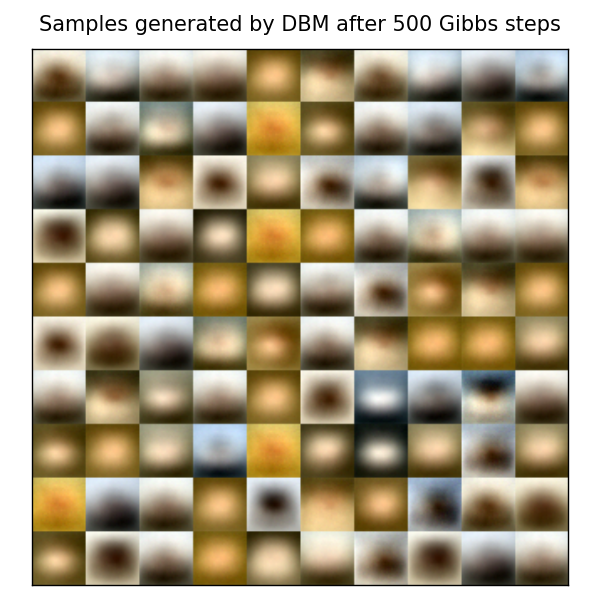

In [16]:
fig = plt.figure(figsize=(6, 6), tight_layout=True)
im = plt.imshow(np.zeros((320, 320, 3), dtype='uint8'), animated=True, vmin=0, vmax=255)
im.axes.tick_params(**tick_params())

anim = im_gif(samples, im, fig, fname='dbm_cifar_naive_samples.gif',
              title_func=lambda i: 'Samples generated by DBM after {0} Gibbs steps'.format(50 * i),
              title_params={'fontsize': 15, 'y': 1.02}, anim_params={'interval': 500}, save_params={'dpi': 144})

display_animation(anim)

# Gaussian RBM discriminative fine-tuning
## load predictions, targets, and fine-tuned weights

In [17]:
y_pred = np.load('../data/grbm_naive_y_pred.npy')
y_test = np.load('../data/grbm_naive_y_test.npy')
W_finetuned = np.load('../data/grbm_naive_W_finetuned.npy')
print accuracy_score(y_test, y_pred)

0.5978


## plot confusion matrix

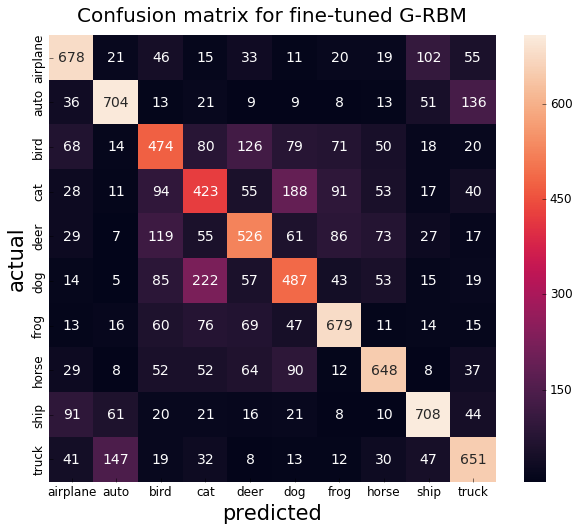

In [18]:
C = confusion_matrix(y_test, y_pred)

fig = plt.figure(figsize=(10, 8))
ax = plot_confusion_matrix(C, labels=get_cifar10_labels(), labels_fontsize=12, fmt='d')
plt.title('Confusion matrix for fine-tuned G-RBM\n', fontsize=20, y=0.97)
plt.savefig('dbm_cifar_naive_grbm_confusion_matrix.png', dpi=144, bbox_inches='tight')

## visualize filters after fine-tuning

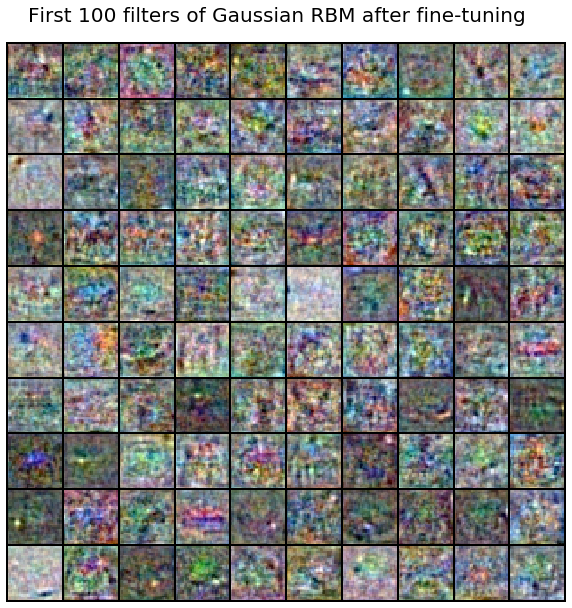

In [19]:
# prepare for plotting
W = im_rescale( W_finetuned.T )

# plot
fig = plt.figure(figsize=(10, 10))
im_plot(W, title='First 100 filters of Gaussian RBM after fine-tuning',
        title_params={'fontsize': 20})
plt.savefig('dbm_cifar_naive_grbm_finetuned.png', dpi=196, bbox_inches='tight');